## Convolution Neural Network

In this tutorial we will implement a simple Convolutional Neural Network in TensorFlow with two convolutional layers, followed by two fully-connected layers at the end. The network structure is shown in the following figure and has classification accuracy of above 99% on MNIST data.

<img src = 'img1.png'>


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

C:\Users\Deepan Das\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.examples.tutorials.mnist import input_data

img_h = img_w = 28  # MNIST images are 28x28
img_size_flat = img_h * img_w  # 28x28=784, the total number of pixels
n_classes = 10  # Number of classes, one class per digit
n_channels = 1

### 1. Loading Data

###### 1.1 Helper Functions

In [3]:
def load_data(mode = 'train'):
    '''
    returns: images and corresponding labels
    '''
    
    mnist = input_data.read_data_sets("MNIST_data/",one_hot = True)
    if mode == 'train':
        x_train, y_train, x_valid, y_valid = mnist.train.images, mnist.train.labels, \
                                             mnist.validation.images, mnist.validation.labels
        x_train, _ = reformat(x_train, y_train)
        x_valid, _ = reformat(x_valid, y_valid)
        return x_train, y_train, x_valid, y_valid
    elif mode == 'test':
        x_test, y_test = mnist.test.images, mnist.test.labels
        x_test, _ = reformat(x_test, y_test)
    return x_test, y_test


def reformat(x,y):
    '''
    Reformats the data to the format acceptable for convolutional layers
    :param x: input array
    :param y: corresponding labels
    :return: reshaped input and labels
    '''
    
    img_size, num_ch, num_class = int(np.sqrt(x.shape[-1])),1, len(np.unique(np.argmax(y,1)))
    dataset = x.reshape((-1, img_size, img_size, num_ch)).astype(np.float32)
    labels = (np.arange(num_class) == y[:, None]).astype(np.float32)
    return dataset, labels

def randomize(x, y):
    """ Randomizes the order of data samples and their corresponding labels"""
    permutation = np.random.permutation(y.shape[0])
    shuffled_x = x[permutation, :, :, :]
    shuffled_y = y[permutation]
    return shuffled_x, shuffled_y

def get_next_batch(x, y, start, end):
    x_batch = x[start:end]
    y_batch = y[start:end]
    return x_batch, y_batch


##### 1.2 Load the data and display sizes

In [5]:
x_train, y_train, x_valid, y_valid = load_data(mode='train')
print("Size of:")
print("- Training-set:\t\t{}".format(len(y_train)))
print("- Validation-set:\t{}".format(len(y_valid)))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Size of:
- Training-set:		55000
- Validation-set:	5000


### 2. Hyperparameters

In [22]:
logs_path = "./logs"
lr = 0.001
epochs = 10
batch_size = 100
display_freq = 100

### 3. Network Configuration

In [82]:
# 1st Convolutional Layer

filter_size1 = 5
num_filters1 = 16
stride1 = 1

#2nd Convolutional Layer

filter_size2 = 5
num_filters2 = 32
stride2 = 1


#FCN
h1 =128 
tf.reset_default_graph()

### 4. Create Network

##### 4.1 Helper function to create new variables

In [83]:
# weight and bais wrappers
def weight_variable(shape):
    """
    Create a weight variable with appropriate initialization
    :param name: weight name
    :param shape: weight shape
    :return: initialized weight variable
    """
    initer = tf.truncated_normal_initializer(stddev=0.01)
    return tf.get_variable('W',
                           dtype=tf.float32,
                           shape=shape,
                           initializer=initer)


def bias_variable(shape):
    """
    Create a bias variable with appropriate initialization
    :param name: bias variable name
    :param shape: bias variable shape
    :return: initialized bias variable
    """
    initial = tf.constant(0., shape=shape, dtype=tf.float32)
    return tf.get_variable('b',
                           dtype=tf.float32,
                           initializer=initial)

##### 4.2 Helper function to create Convolutional Layer

In [84]:
def conv_layer(x, filter_size, num_filters, stride, name):
    """
    Create a 2D convolution layer
    :param x: input from previous layer
    :param filter_size: size of each filter
    :param num_filters: number of filters (or output feature maps)
    :param stride: filter stride
    :param name: layer name
    :return: The output array
    """
    with tf.variable_scope(name):
        num_in_channel = x.get_shape().as_list()[-1]
        shape = [filter_size, filter_size, num_in_channel, num_filters]
        W = weight_variable(shape=shape)
        tf.summary.histogram('weight', W)
        b = bias_variable(shape=[num_filters])
        tf.summary.histogram('bias', b)
        layer = tf.nn.conv2d(x, W,
                             strides=[1, stride, stride, 1],
                             padding="SAME")
        layer += b
        return tf.nn.relu(layer)

##### 4.3 Helper function to create Max Pooling layer

In [85]:
def max_pool(x, ksize, stride, name):
    """
    Create a max pooling layer
    :param x: input to max-pooling layer
    :param ksize: size of the max-pooling filter
    :param stride: stride of the max-pooling filter
    :param name: layer name
    :return: The output array
    """
    return tf.nn.max_pool(x,
                          ksize=[1, ksize, ksize, 1],
                          strides=[1, stride, stride, 1],
                          padding="SAME",
                          name=name)

##### 4.4 Helper function to flatten a layer

In [86]:
def flatten_layer(layer):
    """
    Flattens the output of the convolutional layer to be fed into fully-connected layer
    :param layer: input array
    :return: flattened array
    """
    with tf.variable_scope('Flatten_layer'):
        layer_shape = layer.get_shape()
        num_features = layer_shape[1:4].num_elements()
        layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat

##### 4.5 Helper function to create a new FCN

In [87]:
def fc_layer(x, num_units, name, use_relu=True):
    """
    Create a fully-connected layer
    :param x: input from previous layer
    :param num_units: number of hidden units in the fully-connected layer
    :param name: layer name
    :param use_relu: boolean to add ReLU non-linearity (or not)
    :return: The output array
    """
    with tf.variable_scope(name):
        in_dim = x.get_shape()[1]
        W = weight_variable(shape=[in_dim, num_units])
        tf.summary.histogram('weight', W)
        b = bias_variable(shape=[num_units])
        tf.summary.histogram('bias', b)
        layer = tf.matmul(x, W)
        layer += b
        if use_relu:
            layer = tf.nn.relu(layer)
        return layer

### 5. Network Graph

#####  5.1 Placeholders for x, y and creating network layers

In [88]:
with tf.name_scope('Input'):
    x = tf.placeholder(tf.float32, shape=[None, img_h, img_w, n_channels],name = 'X')
    y = tf.placeholder(tf.float32, shape=[None, n_classes], name = 'Y')

In [89]:
conv1 = conv_layer(x, filter_size1, num_filters1, stride1, name='conv1')
pool1 = max_pool(conv1, ksize=2, stride=2, name='pool1')
conv2 = conv_layer(pool1, filter_size2, num_filters2, stride2, name='conv2')
pool2 = max_pool(conv2, ksize=2, stride=2, name='pool2')
layer_flat = flatten_layer(pool2)
fc1 = fc_layer(layer_flat, h1, 'FC1', use_relu=True)
output_logits = fc_layer(fc1, n_classes, 'OUT', use_relu=False)

##### 5.2 Loss Function, Optimizer and Accuracy

In [90]:
with tf.variable_scope('Train'):
    with tf.variable_scope('Loss'):
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=output_logits), name='loss')
    tf.summary.scalar('loss', loss)
    with tf.variable_scope('Optimizer'):
        optimizer = tf.train.AdamOptimizer(learning_rate=lr, name='Adam-op').minimize(loss)
    with tf.variable_scope('Accuracy'):
        correct_prediction = tf.equal(tf.argmax(output_logits, 1), tf.argmax(y, 1), name='correct_pred')
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')
    tf.summary.scalar('accuracy', accuracy)
    with tf.variable_scope('Prediction'):
        cls_prediction = tf.argmax(output_logits, axis=1, name='predictions')

In [91]:
# Initialize the variables
init = tf.global_variables_initializer()
# Merge all summaries
merged = tf.summary.merge_all()

### 6. Train

In [92]:

sess = tf.InteractiveSession()
sess.run(init)
global_step = 0
summary_writer = tf.summary.FileWriter(logs_path, sess.graph)
# Number of training iterations in each epoch
num_tr_iter = int(len(y_train) / batch_size)
for epoch in range(epochs):
    print('Training epoch: {}'.format(epoch + 1))
    x_train, y_train = randomize(x_train, y_train)
    for iteration in range(num_tr_iter):
        global_step += 1
        start = iteration * batch_size
        end = (iteration + 1) * batch_size
        x_batch, y_batch = get_next_batch(x_train, y_train, start, end)

        # Run optimization op (backprop)
        feed_dict_batch = {x: x_batch, y: y_batch}
        sess.run(optimizer, feed_dict=feed_dict_batch)

        if iteration % display_freq == 0:
            # Calculate and display the batch loss and accuracy
            loss_batch, acc_batch, summary_tr = sess.run([loss, accuracy, merged],
                                                         feed_dict=feed_dict_batch)
            summary_writer.add_summary(summary_tr, global_step)

            print("iter {0:3d}:\t Loss={1:.2f},\tTraining Accuracy={2:.01%}".
                  format(iteration, loss_batch, acc_batch))

    # Run validation after every epoch
    feed_dict_valid = {x: x_valid, y: y_valid}
    loss_valid, acc_valid = sess.run([loss, accuracy], feed_dict=feed_dict_valid)
    print('---------------------------------------------------------')
    print("Epoch: {0}, validation loss: {1:.2f}, validation accuracy: {2:.01%}".
          format(epoch + 1, loss_valid, acc_valid))
    print('---------------------------------------------------------')

Training epoch: 1
iter   0:	 Loss=2.30,	Training Accuracy=12.0%
iter 100:	 Loss=0.51,	Training Accuracy=86.0%
iter 200:	 Loss=0.31,	Training Accuracy=92.0%
iter 300:	 Loss=0.22,	Training Accuracy=91.0%
iter 400:	 Loss=0.13,	Training Accuracy=96.0%
iter 500:	 Loss=0.15,	Training Accuracy=94.0%
---------------------------------------------------------
Epoch: 1, validation loss: 0.11, validation accuracy: 96.8%
---------------------------------------------------------
Training epoch: 2
iter   0:	 Loss=0.10,	Training Accuracy=97.0%
iter 100:	 Loss=0.08,	Training Accuracy=97.0%
iter 200:	 Loss=0.06,	Training Accuracy=99.0%
iter 300:	 Loss=0.06,	Training Accuracy=97.0%
iter 400:	 Loss=0.04,	Training Accuracy=99.0%
iter 500:	 Loss=0.13,	Training Accuracy=95.0%
---------------------------------------------------------
Epoch: 2, validation loss: 0.08, validation accuracy: 97.8%
---------------------------------------------------------
Training epoch: 3
iter   0:	 Loss=0.05,	Training Accuracy=98

### 7. Test

In [93]:
def plot_images(images, cls_true, cls_pred=None, title=None):
    """
    Create figure with 3x3 sub-plots.
    :param images: array of images to be plotted, (9, img_h*img_w)
    :param cls_true: corresponding true labels (9,)
    :param cls_pred: corresponding true labels (9,)
    """
    fig, axes = plt.subplots(3, 3, figsize=(9, 9))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(np.squeeze(images[i]), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            ax_title = "True: {0}".format(cls_true[i])
        else:
            ax_title = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_title(ax_title)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    if title:
        plt.suptitle(title, size=20)
    plt.show(block=False)
    
def plot_example_errors(images, cls_true, cls_pred, title=None):
    """
    Function for plotting examples of images that have been mis-classified
    :param images: array of all images, (#imgs, img_h*img_w)
    :param cls_true: corresponding true labels, (#imgs,)
    :param cls_pred: corresponding predicted labels, (#imgs,)
    """
    # Negate the boolean array.
    incorrect = np.logical_not(np.equal(cls_pred, cls_true))

    # Get the images from the test-set that have been
    # incorrectly classified.
    incorrect_images = images[incorrect]

    # Get the true and predicted classes for those images.
    cls_pred = cls_pred[incorrect]
    cls_true = cls_true[incorrect]

    # Plot the first 9 images.
    plot_images(images=incorrect_images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9],
                title=title)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
---------------------------------------------------------
Test loss: 0.04, test accuracy: 98.9%
---------------------------------------------------------


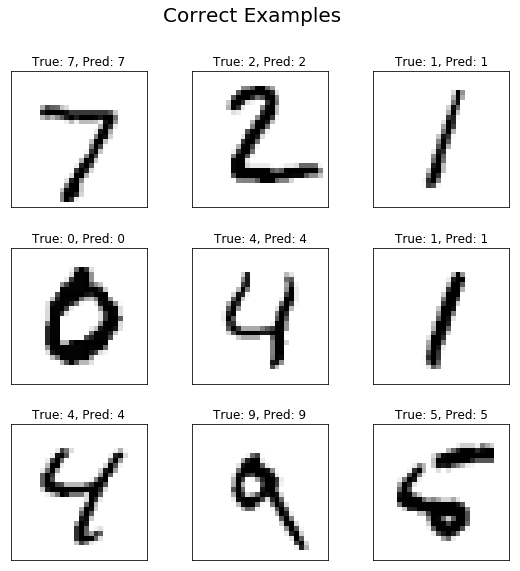

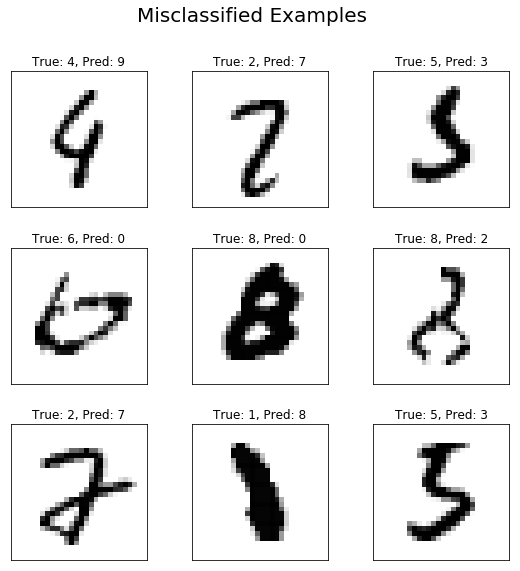

In [94]:
# Test the network when training is done
x_test, y_test = load_data(mode='test')
feed_dict_test = {x: x_test, y: y_test}
loss_test, acc_test = sess.run([loss, accuracy], feed_dict=feed_dict_test)
print('---------------------------------------------------------')
print("Test loss: {0:.2f}, test accuracy: {1:.01%}".format(loss_test, acc_test))
print('---------------------------------------------------------')

# Plot some of the correct and misclassified examples
cls_pred = sess.run(cls_prediction, feed_dict=feed_dict_test)
cls_true = np.argmax(y_test, axis=1)
plot_images(x_test, cls_true, cls_pred, title='Correct Examples')
plot_example_errors(x_test, cls_true, cls_pred, title='Misclassified Examples')
plt.show()